In [26]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("../../choroid-plexus/new_annotations.h5ad")
adata = adata[adata.obs["Cell.Subtype"].ne("Doublet")][::10]

In [2]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.external.pp.harmony_integrate(adata, key="orig.ident")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep="X_pca_harmony")
sc.tl.umap(adata, min_dist=0.3, spread=1.0, random_state=42)

/Users/jameshaberberger/GitHub/CHOIR/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-06-15 12:26:11,120 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 12:26:12,143 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 12:26:12,179 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 12:26:13,746 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 12:26:15,353 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 12:26:16,779 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 12:26:18,133 - harmonypy - INFO - Iteration 5 of 10
2025-06-15 12:26:19,326 - harmo

In [51]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import silhouette_score

def optimal_clustering(adata):
    # We'll be using a copy of the original AnnData object.
    # Return the best resolution and labels.
    adata_copy = adata.copy()

    sc.pp.pca(adata_copy, n_comps=10, svd_solver="arpack")
    sc.external.pp.harmony_integrate(adata_copy, key="orig.ident")
    sc.pp.neighbors(adata_copy, n_neighbors=10, n_pcs=10, use_rep="X_pca_harmony")

    best_res = 0
    best_score = -1
    best_labels = pd.Series(["X"] * adata_copy.n_obs)

    # Resolution range.
    for res in np.linspace(0.05, 2.0, 40):

        # Leiden Clustering.
        sc.tl.leiden(adata_copy, resolution=0.1, flavor="igraph", n_iterations=2)
        if adata_copy.obs["leiden"].nunique() < 2:
            continue
        new_score = silhouette_score(adata_copy.X, adata_copy.obs["leiden"], metric='euclidean', sample_size=1000)

        # New Score.
        if new_score > best_score:
            best_score = new_score
            best_res = res
            best_labels = adata_copy.obs["leiden"].copy()
        else:
            print(f"Resolution {res:.2f} did not improve silhouette score: {new_score:.4f}")
            return res, best_labels
    
    return best_res, best_labels


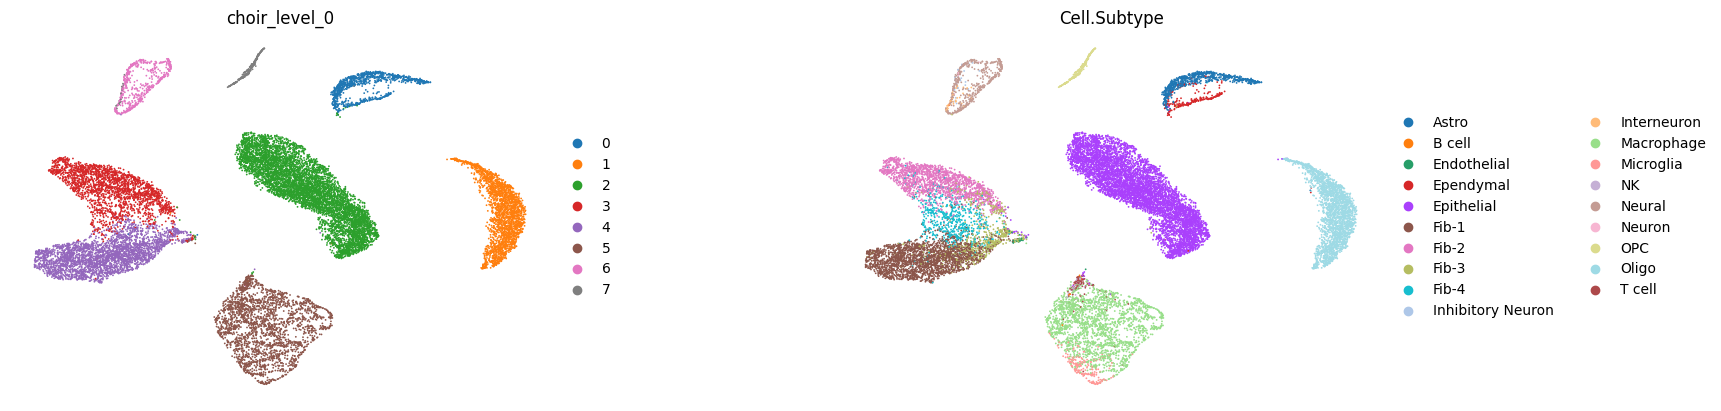

In [133]:
sc.pl.umap(
    adata,
    color=["choir_level_0", "Cell.Subtype"],
    frameon=False,
    wspace=0.4,
    hspace=0.4,
    ncols=3
)

In [ ]:
import scipy.stats
from tqdm import trange
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier

from collections import defaultdict
prefix_table = defaultdict(list)

def get_prefix_table(adata, column):
    for x in adata.obs[column].dropna().unique():
        prefix = ".".join(x.split(".")[:-1])
        prefix_table[prefix].append(x)
    return prefix_table

def permutation_testing(X, y, n_permutations=20, shuffle=True):
    permutation_accuracies = []
    for i in range(n_permutations):

        if shuffle:
            # Shuffle the labels
            y_permuted = np.random.permutation(y)
        
        else:
            # Use the original labels
            y_permuted = y

        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y_permuted,
            stratify=y_permuted,
            test_size=0.8,
        )

        model.fit(X_train, y_train)
        perm_accuracy = model.score(X_test, y_test)
        permutation_accuracies.append(perm_accuracy)

    return np.array(permutation_accuracies)


Attempting to merge choir_level_5...


  2%|▏         | 2/99 [00:02<01:32,  1.05it/s]/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_39244/1586125064.py:53: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata[adata.obs[f"choir_level_{i+1}"].isin(children)].obs[f"choir_level_{i+1}"] = None
  8%|▊         | 8/99 [00:08<01:25,  1.06it/s]/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_39244/1586125064.py:53: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata[adata.obs[f"choir_level_{i+1}"].isin(children)].obs[f"choir_level_{i+1}"] = None
100%|██████████| 99/99 [00:10<00:00,  9.03it/s]


Attempting to merge choir_level_4...


100%|██████████| 99/99 [00:50<00:00,  1.98it/s]


Attempting to merge choir_level_3...


100%|██████████| 99/99 [01:49<00:00,  1.11s/it] 


Attempting to merge choir_level_2...


100%|██████████| 99/99 [02:28<00:00,  1.50s/it] 


In [233]:
import pandas as pd
import plotly.graph_objects as go

def visualize_tree_sankey(df, level_columns, height=600, show_labels=True):
    # Forward-fill missing values to preserve hierarchy shape
    df_filled = df[level_columns].copy().ffill(axis=1)

    # Collect edges: (source, target) -> count
    edge_counts = {}
    node_levels = {}  # track earliest level of appearance

    for _, row in df_filled.iterrows():
        for i in range(len(level_columns) - 1):
            src = row[level_columns[i]]
            tgt = row[level_columns[i + 1]]
            if pd.isna(src) or pd.isna(tgt) or src == tgt:
                continue
            edge = (src, tgt)
            edge_counts[edge] = edge_counts.get(edge, 0) + 1
            node_levels[src] = min(i, node_levels.get(src, i))
            node_levels[tgt] = min(i + 1, node_levels.get(tgt, i + 1))

    # Build node list and indexing
    all_nodes = sorted(node_levels, key=lambda k: (node_levels[k], k))
    node_index = {name: i for i, name in enumerate(all_nodes)}

    # Sankey data
    sources = [node_index[src] for (src, tgt) in edge_counts]
    targets = [node_index[tgt] for (src, tgt) in edge_counts]
    values = list(edge_counts.values())

    # Node positions: map level to normalized x (0.0 - 1.0)
    max_level = max(node_levels.values())
    node_x = [node_levels[name] / max(max_level, 1) for name in all_nodes]

    # Plot
    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes if show_labels else [""] * len(all_nodes),
            x=node_x  # force alignment by level
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values
        )
    ))

    fig.update_layout(
        title_text="Hierarchical Levels Sankey Diagram",
        font_size=10,
        height=height
    )
    fig.show()

In [234]:
visualize_tree_sankey(
    adata.obs[adata.obs.columns[-6:-3]].sort_values(by=adata.obs.columns[-6:-3].tolist()),
    adata.obs.columns[-6:-3],
    height=1000,
    show_labels=True
)

# Testing the new clusters

2025-06-15 13:53:06,097 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 13:53:06,183 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 13:53:06,185 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 13:53:06,273 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 13:53:06,369 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 13:53:06,436 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 13:53:06,483 - harmonypy - INFO - Iteration 5 of 10
2025-06-15 13:53:06,530 - harmonypy - INFO - Iteration 6 of 10
2025-06-15 13:53:06,569 - harmonypy - INFO - Iteration 7 of 10
2025-06-15 13:53:06,612 - harmonypy - INFO - Iteration 8 of 10
2025-06-15 13:53:06,646 - harmonypy - INFO - Iteration 9 of 10
2025-06-15 13:53:06,683 - harmonypy - INFO - Iteration 10 of 10
2025-06-15 13:53:06,726 - harmonypy - INFO - Stopped before convergence


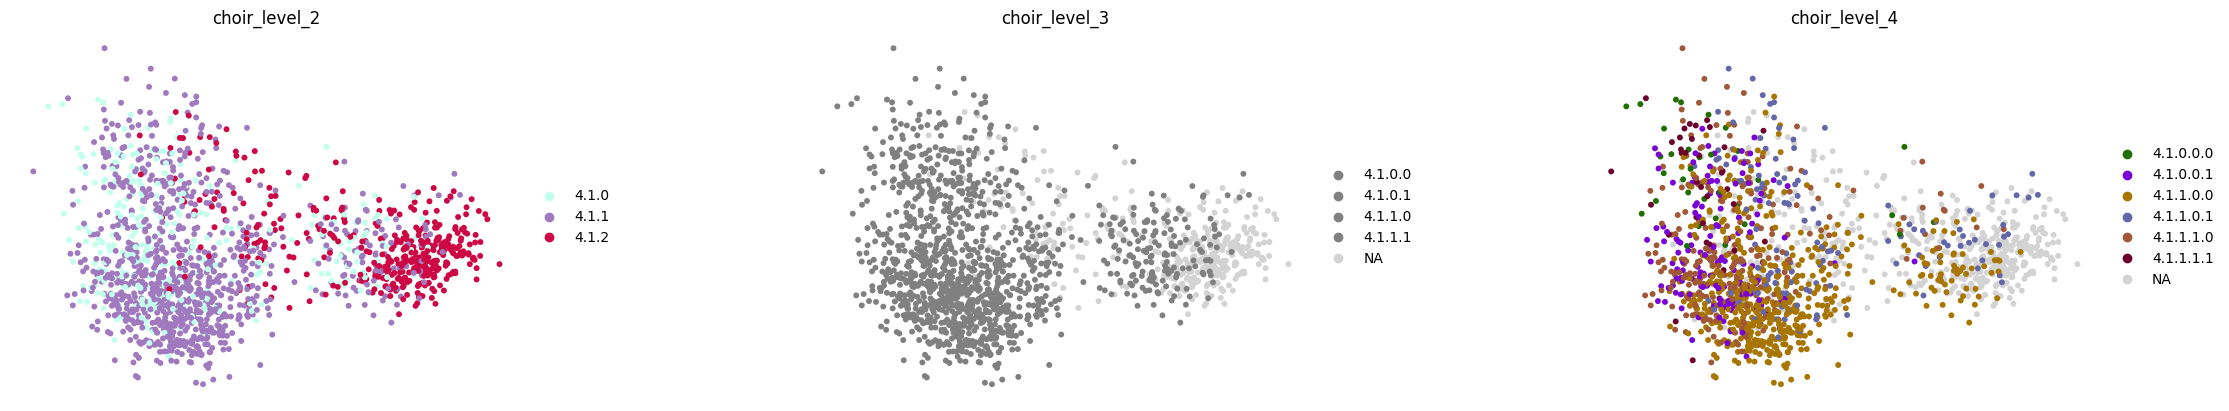

In [229]:
adata_copy = adata[adata.obs["choir_level_1"].eq("4.1")].copy()
sc.pp.pca(adata_copy, n_comps=10, svd_solver="arpack")
sc.external.pp.harmony_integrate(adata_copy, key="orig.ident")
sc.pp.neighbors(adata_copy, n_neighbors=10, n_pcs=10, use_rep="X_pca_harmony")
sc.tl.umap(adata_copy, min_dist=0.3, spread=1.0, random_state=42)
sc.pl.pca(
    adata_copy,
    color=["choir_level_2", "choir_level_3", "choir_level_4"],
    frameon=False,
    wspace=0.4,
    hspace=0.4,
    ncols=3
)

# One big class

In [27]:
import numpy as np
import scanpy as sc
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import scipy.stats
from tqdm import trange
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier

from collections import defaultdict

class CHOIR:

    def __init__(self, adata):
        """
        Initialize the CHOIR model with an AnnData object.
        
        Parameters:
        adata (AnnData): The annotated data matrix.
        """
        self.adata = adata

    @staticmethod
    def optimal_clustering(adata):
        # We'll be using a copy of the original AnnData object.
        # Return the best resolution and labels.
        adata_copy = adata.copy()

        sc.pp.pca(adata_copy, n_comps=10, svd_solver="arpack")
        sc.external.pp.harmony_integrate(adata_copy, key="orig.ident")
        sc.pp.neighbors(adata_copy, n_neighbors=10, n_pcs=10, use_rep="X_pca_harmony")

        best_res = 0
        best_score = -1
        best_labels = pd.Series(["X"] * adata_copy.n_obs)

        # Resolution range.
        for res in np.linspace(0.05, 2.0, 40):

            # Leiden Clustering.
            sc.tl.leiden(adata_copy, resolution=0.1, flavor="igraph", n_iterations=2)
            if adata_copy.obs["leiden"].nunique() < 2:
                continue
            new_score = silhouette_score(adata_copy.X, adata_copy.obs["leiden"], metric='euclidean', sample_size=1000)

            # New Score.
            if new_score > best_score:
                best_score = new_score
                best_res = res
                best_labels = adata_copy.obs["leiden"].copy()
            else:
                print(f"Resolution {res:.2f} did not improve silhouette score: {new_score:.4f}")
                return res, best_labels
        
        return best_res, best_labels

    @staticmethod
    def get_prefix_table(adata, column):
        prefix_table = defaultdict(list)
        for x in adata.obs[column].dropna().unique():
            prefix = ".".join(x.split(".")[:-1])
            prefix_table[prefix].append(x)
        return prefix_table

    @staticmethod
    def permutation_testing(X, y, n_permutations=20, shuffle=True):
        model = SGDClassifier(class_weight="balanced", max_iter=1000, random_state=42)
        permutation_accuracies = []
        for i in range(n_permutations):

            if shuffle:
                # Shuffle the labels
                y_permuted = np.random.permutation(y)
            
            else:
                # Use the original labels
                y_permuted = y

            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y_permuted,
                stratify=y_permuted,
                test_size=0.8,
            )

            model.fit(X_train, y_train)
            perm_accuracy = model.score(X_test, y_test)
            permutation_accuracies.append(perm_accuracy)

        return np.array(permutation_accuracies)

    def run(self, sample_id = "orig.ident"):

        _, labels = self.optimal_clustering(self.adata)
        self.adata.obs["choir_level_0"] = labels

        # Setup the initial clusters.
        for i in trange(1, 6):
            self.adata.obs[f"choir_level_{i}"] = None
            print(f"Running choir_level_{i}...")
            for cluster in self.adata.obs[f"choir_level_{i-1}"].unique():
                if cluster is None:
                    continue

                adata_subset = self.adata[self.adata.obs[f"choir_level_{i-1}"] == cluster].copy()

                if adata_subset.n_obs < 100:
                    continue

                sc.pp.pca(adata_subset, n_comps=10, svd_solver="arpack")
                if sample_id != None:
                    sc.external.pp.harmony_integrate(adata_subset, key="orig.ident")
                    sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=10, use_rep="X_pca_harmony")
                else:
                    sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=10, use_rep="X_pca")

                best_res, labels = self.optimal_clustering(adata_subset)

                self.adata[self.adata.obs[f"choir_level_{i-1}"] == cluster].obs[f"choir_level_{i}"] = labels

        for i in list(range(1, 5))[::-1]:
            print(f"Attempting to merge choir_level_{i+1}...")
            prefix_table = self.get_prefix_table(adata=self.adata, column=f"choir_level_{i+1}")

            for parent, children in tqdm(prefix_table.items()):
                if len(children) < 2:
                    continue

                X = self.adata[self.adata.obs[f"choir_level_{i+1}"].isin(children)].X
                y = self.adata[self.adata.obs[f"choir_level_{i+1}"].isin(children)].obs[f"choir_level_{i+1}"]

                if len(y.unique()) < 2:
                    continue

                true_accuracy = pd.Series(self.permutation_testing(X, y, shuffle=False))
                bootstrapped_null = pd.Series(self.permutation_testing(X, y))

                statistical_test = scipy.stats.ttest_ind(true_accuracy, bootstrapped_null, equal_var=False, nan_policy="omit")

                if statistical_test.pvalue > 0.05:
                    self.adata[self.adata.obs[f"choir_level_{i+1}"].isin(children)].obs[f"choir_level_{i+1}"] = None

In [28]:
choir = CHOIR(adata)
choir.run(sample_id="orig.ident")

2025-06-15 20:34:15,325 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 20:34:15,991 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 20:34:16,039 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 20:34:17,605 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 20:34:19,110 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 20:34:20,551 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 20:34:22,210 - harmonypy - INFO - Iteration 5 of 10
2025-06-15 20:34:23,912 - harmonypy - INFO - Iteration 6 of 10
2025-06-15 20:34:25,421 - harmonypy - INFO - Iteration 7 of 10
2025-06-15 20:34:26,897 - harmonypy - INFO - Iteration 8 of 10
2025-06-15 20:34:28,392 - harmonypy - INFO - Iteration 9 of 10
2025-06-15 20:34:29,467 - harmonypy - INFO - Iteration 10 of 10
2025-06-15 20:34:30,664 - harmonypy - INFO - Stopped before convergence


Resolution 0.20 did not improve silhouette score: 0.0027


/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_31782/3966442822.py:96: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata.obs["choir_level_0"] = labels
  0%|          | 0/5 [00:00<?, ?it/s]

Running choir_level_1...


2025-06-15 20:34:43,962 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 20:34:44,265 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 20:34:44,278 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 20:34:44,791 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 20:34:45,261 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 20:34:45,754 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 20:34:46,235 - harmonypy - INFO - Iteration 5 of 10
2025-06-15 20:34:46,770 - harmonypy - INFO - Iteration 6 of 10
2025-06-15 20:34:47,230 - harmonypy - INFO - Iteration 7 of 10
2025-06-15 20:34:47,714 - harmonypy - INFO - Iteration 8 of 10
2025-06-15 20:34:48,031 - harmonypy - INFO - Iteration 9 of 10
2025-06-15 20:34:48,505 - harmonypy - INFO - Iteration 10 of 10
2025-06-15 20:34:48,976 - harmonypy - INFO - Stopped before convergence
2025-06-15 20:34:49,550 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 20:34:49,

Resolution 0.15 did not improve silhouette score: -0.0247


/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_31782/3966442822.py:120: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata[self.adata.obs[f"choir_level_{i-1}"] == cluster].obs[f"choir_level_{i}"] = labels
2025-06-15 20:34:55,848 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 20:34:55,983 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 20:34:55,987 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 20:34:56,140 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 20:34:56,278 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 20:34:56,418 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 20:34:56,540 - harmonypy - INFO - Iteration 5 of 10
2025-06-15 20:34:56,651 - harmonypy - INFO - Iteration 6 of 10
2025-06-15 20:34:56,794 - harmonypy - INFO - Iteration 7 of 10
2025-06-15 20:34:56,919 - harmonypy - INFO - Iteration 8 of 10
2025-06-15 20:34:57,004 - harmonypy

Resolution 0.15 did not improve silhouette score: 0.0640


/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_31782/3966442822.py:120: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata[self.adata.obs[f"choir_level_{i-1}"] == cluster].obs[f"choir_level_{i}"] = labels
2025-06-15 20:35:01,604 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 20:35:01,846 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 20:35:01,853 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 20:35:02,157 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 20:35:02,439 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 20:35:02,731 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 20:35:03,030 - harmonypy - INFO - Iteration 5 of 10
2025-06-15 20:35:03,318 - harmonypy - INFO - Iteration 6 of 10
2025-06-15 20:35:03,607 - harmonypy - INFO - Iteration 7 of 10
2025-06-15 20:35:03,890 - harmonypy - INFO - Iteration 8 of 10
2025-06-15 20:35:04,180 - harmonypy

Resolution 0.10 did not improve silhouette score: 0.3061


/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_31782/3966442822.py:120: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata[self.adata.obs[f"choir_level_{i-1}"] == cluster].obs[f"choir_level_{i}"] = labels
2025-06-15 20:35:12,441 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 20:35:12,659 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 20:35:12,668 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 20:35:12,983 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 20:35:13,301 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 20:35:13,621 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 20:35:13,933 - harmonypy - INFO - Iteration 5 of 10
2025-06-15 20:35:14,252 - harmonypy - INFO - Iteration 6 of 10
2025-06-15 20:35:14,454 - harmonypy - INFO - Iteration 7 of 10
2025-06-15 20:35:14,776 - harmonypy - INFO - Iteration 8 of 10
2025-06-15 20:35:14,996 - harmonypy

Resolution 0.10 did not improve silhouette score: -0.0437


2025-06-15 20:35:20,261 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 20:35:20,280 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 20:35:20,299 - harmonypy - INFO - Converged after 4 iterations
2025-06-15 20:35:20,423 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 20:35:20,439 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 20:35:20,440 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 20:35:20,467 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 20:35:20,493 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 20:35:20,512 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 20:35:20,530 - harmonypy - INFO - Converged after 4 iterations


Resolution 0.10 did not improve silhouette score: 0.2215


/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_31782/3966442822.py:120: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata[self.adata.obs[f"choir_level_{i-1}"] == cluster].obs[f"choir_level_{i}"] = labels
2025-06-15 20:35:21,333 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-15 20:35:21,426 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-15 20:35:21,428 - harmonypy - INFO - Iteration 1 of 10
2025-06-15 20:35:21,543 - harmonypy - INFO - Iteration 2 of 10
2025-06-15 20:35:21,644 - harmonypy - INFO - Iteration 3 of 10
2025-06-15 20:35:21,730 - harmonypy - INFO - Iteration 4 of 10
2025-06-15 20:35:21,826 - harmonypy - INFO - Iteration 5 of 10
2025-06-15 20:35:21,901 - harmonypy - INFO - Iteration 6 of 10
2025-06-15 20:35:21,967 - harmonypy - INFO - Iteration 7 of 10
2025-06-15 20:35:22,067 - harmonypy - INFO - Iteration 8 of 10
2025-06-15 20:35:22,129 - harmonypy

Resolution 0.20 did not improve silhouette score: 0.0187
Running choir_level_2...
Running choir_level_3...
Running choir_level_4...
Running choir_level_5...
Attempting to merge choir_level_5...


0it [00:00, ?it/s]


Attempting to merge choir_level_4...


0it [00:00, ?it/s]


Attempting to merge choir_level_3...


0it [00:00, ?it/s]


Attempting to merge choir_level_2...


0it [00:00, ?it/s]
